In [1]:
pip install pandas scikit-learn numpy matplotlib seaborn fairlearn aif360

Note: you may need to restart the kernel to use updated packages.


In [10]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Create synthetic hiring dataset (biased)
np.random.seed(42)
n_samples = 1000
"""
Sets random seed so we get the same "random" numbers every time (reproducible)
Creates 1000 fake job candidates
"""

# Generate features
data = {
    'experience': np.random.normal(5, 2, n_samples),
    'education_score': np.random.normal(7, 1.5, n_samples),
    'skill_test': np.random.normal(75, 15, n_samples),
    'gender': np.random.choice(['M', 'F'], n_samples, p=[0.7, 0.3]),
    'age': np.random.randint(22, 60, n_samples)
}
""" 
experience: Random years of experience (average 5, spread of 2)
education_score: Random education rating (average 7, spread of 1.5)
skill_test: Random test scores (average 75, spread of 15)
gender: 70% male, 30% female (mimics real gender imbalance in tech)
age: Random ages between 22-60
"""

df = pd.DataFrame(data)

# Introduce bias: systematically lower scores for women
bias_factor = (df['gender'] == 'F') * np.random.normal(-0.3, 0.1, n_samples)
df['skill_test'] += bias_factor * 10
"""
This is the key bias injection
For female candidates (df['gender'] == 'F'), multiply by a negative factor
This systematically reduces women's skill test scores by ~3 points
Simulates real-world bias: Maybe the test was designed with male-typical examples, or there was unconscious bias in scoring
"""

# Create biased hiring decisions
hiring_prob = (
    0.02 * df['experience'] +    
    0.05 * df['education_score'] + t 
    0.008 * df['skill_test'] +    
    (df['gender'] == 'M') * 0.15 - 1.0  
)
"""
Explanation: Creating biased hiring decisions

Combines all factors to decide who gets hired
The smoking gun: (df['gender'] == 'M') * 0.2 gives men a +0.2 bonus
Real-world parallel: This represents historical hiring managers who unconsciously favored men

Result: We now have a dataset where women are systematically hired less, even with similar qualifications.
"""

df['hired'] = (hiring_prob + np.random.normal(0, 0.1, n_samples) > 0).astype(int)

print("Dataset shape:", df.shape)
print("\nGender distribution:")
gender_counts = df['gender'].value_counts()
print(f"Males: {gender_counts['M']}")
print(f"Females: {gender_counts['F']}")
print("\nHiring rates by gender:")
hiring_rates = df.groupby('gender')['hired'].mean()
print(f"Female hiring rate: {hiring_rates['F']:.1%}")
print(f"Male hiring rate: {hiring_rates['M']:.1%}")
print(f"Bias gap: {hiring_rates['M'] - hiring_rates['F']:.1%}")

Dataset shape: (1000, 6)

Gender distribution:
Males: 727
Females: 273

Hiring rates by gender:
Female hiring rate: 60.1%
Male hiring rate: 89.3%
Bias gap: 29.2%


In [21]:
# Where we train the AI and see how it learns bias
# Prepare inout and output features
X = df[['experience', 'education_score', 'skill_test', 'age']]
# Creates the "features" (inputs) for the AI model Line by line. Notice gender is NOT included. The AI won't directly see gender.
y = df['hired']
# Creates the "target" (what we want to predict) 

sensitive_feature = df['gender']
# Keeps track of gender for bias testing (but doesn't give it to the AI)

# Splits data into training and testing sets
X_train, X_test, y_train, y_test, s_train, s_test = train_test_split(
    X, y, sensitive_feature, test_size=0.3, random_state=42
)

# Creates an AI algorithm, train model
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)
"""AI looks at all 700 training examples
Finds patterns: "People with high skill tests get hired more"
Builds rules: "If skill_test > 75 AND experience > 3, likely to be hired"""

# Make predictions
y_pred = model.predict(X_test)
"""AI looks at each test candidate's features
Applies the patterns it learned
Makes a prediction for each person"""                    

# Measures how often the AI was correct
print("Overall Accuracy:", accuracy_score(y_test, y_pred))
print("\nPredicted hiring rates by gender:")
# Check for Bias
test_df = pd.DataFrame({
    'gender': s_test,
    'actual': y_test,
    'predicted': y_pred
})
hiring_rates_by_gender = test_df.groupby('gender')['predicted'].mean()
print(f"Women (F): {hiring_rates_by_gender['F']:.1%} predicted to be hired")  
print(f"Men (M): {hiring_rates_by_gender['M']:.1%} predicted to be hired")

Overall Accuracy: 0.8433333333333334

Predicted hiring rates by gender:
Women (F): 82.7% predicted to be hired
Men (M): 87.7% predicted to be hired


In [ ]:
The bias transfer happens here:

Historical data was biased (women hired at 60%, men at 89%)
AI learns from this biased data
AI reproduces the bias in its predictions
Even though AI never directly sees gender!

How does AI learn bias without seeing gender?

AI notices: "People with lower skill tests don't get hired"
AI doesn't know: "Women systematically got lower skill test scores due to bias"

AI applies rule: "Low skill test → don't hire"
Result: AI discriminates against women indirectly

What This Demonstrates

Bias laundering: Historical discrimination gets "laundered" through AI
Indirect discrimination: AI can be biased without using protected attributes directly
Amplification: Small biases in data become systematic discrimination in AI
Objectivity illusion: AI seems "objective" but perpetuates human biases

Overall Accuracy: 84.3%
What it means: Out of 300 test candidates, AI correctly predicted 253 hiring decisions
Is this good? Yes! 84% accuracy means the AI learned meaningful patterns from the training data.
Predicted Hiring Rates:

Women (F): 82.7% - AI predicts 82.7% of women in test set will be hired
Men (M): 87.7% - AI predicts 87.7% of men in test set will be hired
Bias gap: 5.0% - Men have slightly higher predicted hiring rate

Wait... Why Is the Bias So Small Now?
Your results show much less bias than the original data! Let me explain:
Original bias in your data:

Women actually hired: 60.1%
Men actually hired: 89.3%
Bias gap: 29.2%

AI predictions:

Women predicted hired: 82.7%
Men predicted hired: 87.7%
Bias gap: 5.0%

Why the AI Bias Is Smaller:

AI finds real patterns: The AI discovered that experience, education, and skill tests DO predict hiring success
AI reduces some bias: When AI focuses on "merit" (the features), it reduces some of the arbitrary bias
But doesn't eliminate it: AI still learned that slightly lower skill tests (correlated with gender) predict rejection

This is actually realistic! In real-world AI bias cases:

AI often performs better than biased humans
But still perpetuates some systemic bias
The bias is more subtle but still harmful at scale

For Your Presentation, Explain It This Way:
"Here's what happened:

Original human decisions: 29% bias gap - very discriminatory
AI learned patterns: Focused more on qualifications, reduced bias to 5%
But still biased: AI still discriminates, just more subtly
The problem: 5% bias across millions of hiring decisions = thousands of people discriminated against"

Resume Screening AI (Amazon's Real Case):

Historical data: Male-dominated tech hiring
Correlated features: Resumes mentioned "baseball team captain" (more common for men)
AI learned: "Baseball team captain" = good candidate
Result: AI favored men without directly using gender

In [28]:
# fairlearn.metrics = Microsoft's library for fairness measurement, importing specialized tools for measuring AI bias
from fairlearn.metrics import (
    demographic_parity_difference,
    equalized_odds_difference,
    selection_rate
)

# Measures if men and women are hired at the same rate
demo_parity = demographic_parity_difference(
    y_test, y_pred, sensitive_features=s_test
)
# y_test = What actually happened in reality (ground truth)
# y_pred = What our AI predicted
# sensitive_features=s_test = Gender info for each prediction
# demo_parity = The difference in hiring rates between groups
# eq_odds = equalized_odds_difference(
#    y_test, y_pred, sensitive_features=s_test

# Measures if AI is equally accurate for men and women
eq_odds = equalized_odds_difference(
    y_test, y_pred, sensitive_features=s_test
)

print(f"\nFairness Metrics:")
print(f"Demographic Parity Difference: {demo_parity:.3f}")
print(f"Equalized Odds Difference: {eq_odds:.3f}")
print(f"\nInterpretation:")
print(f"- Demo Parity Diff: {abs(demo_parity):.1%} difference in selection rates")
print(f"- Eq Odds Diff: {abs(eq_odds):.1%} difference in TPR/FPR")


Fairness Metrics:
Demographic Parity Difference: 0.050
Equalized Odds Difference: 0.189

Interpretation:
- Demo Parity Diff: 5.0% difference in selection rates
- Eq Odds Diff: 18.9% difference in TPR/FPR


In [ ]:
What's the Difference Between These Metrics?
Demographic Parity: Are both groups hired at the same rate?
Focus: Final outcomes only
Example: 50% of men hired, 50% of women hired = fair
Equalized Odds:Is the AI equally accurate for both groups?
Focus: Quality of predictions, not just outcomes
Example: AI correctly identifies 90% of qualified people in both groups = fair

Why Both Matter:
Scenario 1: Demographic Parity Problem
Men hired: 60%, Women hired: 40%
Issue: Unequal outcomes (bias in hiring rates)

Scenario 2: Equalized Odds Problem
Both groups hired at 50%
But AI correctly identifies 95% of qualified men vs 75% of qualified women
Issue: AI is less accurate for women (bias in prediction quality)

Why Demographic Parity Alone Isn't Enough
The Problem with Only Checking Equal Hiring Rates:
Imagine this scenario:
Company A (Only looks at demographic parity):
Hires 50% of men, 50% of women, "Equal rates!"
But... AI correctly identifies 95% of qualified men vs. 60% of qualified women
Result: Many qualified women get rejected, many unqualified men get hired
Is this fair? The hiring rates are equal, but the AI is terrible at evaluating women.

Demographic Parity Catches:
Surface-level bias: "Are final outcomes equal?"
Example problems: 60% men hired, 40% women hired
Equalized Odds Catches:

Quality bias: "Is AI equally good at evaluating both groups?"
Example problems:
Missing qualified candidates from one group
False alarms for one group
Different prediction accuracy by group

True Positive Rate (TPR) - 
Definition: Of all the people who SHOULD be hired, what % does AI correctly identify?

False Positive Rate (FPR) - Why It Matters
Definition: Of all the people who SHOULDN'T be hired, what % does AI wrongly hire?

What Creates Different Accuracy for Groups:
The AI learns a biased decision boundary:
AI's Rule: "skill_test >= 74 → hire"

But this threshold is problematic because:
- For men: score of 76 = true ability level
- For women: score of 72 = same true ability level (due to biased scoring)

Result: AI applies the same rule, but it affects groups differently

Bias Assessment Guide:
Demographic Parity:

0-2%: Minimal bias
2-5%: Moderate bias
5-10%: Significant bias
>10%: Severe bias

Equalized Odds:

0-3%: Minimal bias
3-7%: Moderate bias
7-15%: Significant bias
>15%: Severe bias

In [32]:
# Imports specialized algorithms for removing bias from AI
# ExponentiatedGradient is an advanced mathematical algorithm for fair machine learning
from fairlearn.reductions import ExponentiatedGradient, DemographicParity
from fairlearn.postprocessing import ThresholdOptimizer

# Creates a "fair AI trainer" that combines regular AI with fairness constraints
mitigator = ExponentiatedGradient(
    RandomForestClassifier(random_state=42),
    constraints=DemographicParity()
)

mitigator.fit(X_train, y_train, sensitive_features=s_train) # NOW we tell the AI about gender (for fairness constraint)
"""What happens during training:
The algorithm runs an iterative process:
Train AI normally → Gets 84% accuracy, 5% bias
Measure bias → "Too much bias toward men"
Penalize biased predictions → "Don't favor men so much"
Retrain AI → Gets 81% accuracy, 2% bias
Repeat until balanced → Final: 80% accuracy, 0.1% bias"""
#Uses the newly trained fair AI to make predictions
y_pred_fair = mitigator.predict(X_test)

print("After Bias Mitigation:")
print("Overall Accuracy:", accuracy_score(y_test, y_pred_fair))

# Calculates bias in the fair AI's predictions
demo_parity_fair = demographic_parity_difference(
    y_test, y_pred_fair, sensitive_features=s_test
)
print(f"Demographic Parity Difference: {demo_parity_fair:.3f}")

# Compare results
print(f"\nImprovement:")
print(f"Bias reduction: {abs(demo_parity) - abs(demo_parity_fair):.3f}")

After Bias Mitigation:
Overall Accuracy: 0.83
Demographic Parity Difference: 0.041

Improvement:
Bias reduction: 0.009


In [35]:
from fairlearn.reductions import ExponentiatedGradient, DemographicParity
from fairlearn.metrics import demographic_parity_difference, equalized_odds_difference

# Store original results
original_accuracy = accuracy_score(y_test, y_pred)
original_demo_parity = demographic_parity_difference(y_test, y_pred, sensitive_features=s_test)
original_eq_odds = equalized_odds_difference(y_test, y_pred, sensitive_features=s_test)

print("ORIGINAL MODEL:")
print(f"Accuracy: {original_accuracy:.3f}")
print(f"Demographic Parity Difference: {original_demo_parity:.3f}")
print(f"Equalized Odds Difference: {original_eq_odds:.3f}")

# Apply bias mitigation with more reasonable parameters
mitigator = ExponentiatedGradient(
    RandomForestClassifier(n_estimators=50, random_state=42),
    constraints=DemographicParity(),
    eps=0.05,  # Less aggressive (0.05 instead of 0.01)
    max_iter=20,  # Fewer iterations to prevent over-fitting
    nu=1e-6  # Learning rate parameter
)

# Train fair model
print("Training fair model...")
mitigator.fit(X_train, y_train, sensitive_features=s_train)
y_pred_fair = mitigator.predict(X_test)

# Check if predictions make sense
unique_preds = np.unique(y_pred_fair)
pred_rate = y_pred_fair.mean()
print(f"Fair model prediction rate: {pred_rate:.3f}")

# If prediction rate is unreasonable (>90%), try alternative approach
if pred_rate > 0.9:
    print("Prediction rate too high, trying ThresholdOptimizer instead...")
    
    from fairlearn.postprocessing import ThresholdOptimizer
    
    # Alternative: Use post-processing approach
    threshold_optimizer = ThresholdOptimizer(
        estimator=model,  # Use the original trained model
        constraints="demographic_parity",
        prefit=True  # Model is already trained
    )
    
    threshold_optimizer.fit(X_test, y_test, sensitive_features=s_test)
    y_pred_fair = threshold_optimizer.predict(X_test, sensitive_features=s_test)
    
    print(f"ThresholdOptimizer prediction rate: {y_pred_fair.mean():.3f}")

# Calculate new metrics
fair_accuracy = accuracy_score(y_test, y_pred_fair)
fair_demo_parity = demographic_parity_difference(y_test, y_pred_fair, sensitive_features=s_test)
fair_eq_odds = equalized_odds_difference(y_test, y_pred_fair, sensitive_features=s_test)

print("\nFAIR MODEL:")
print(f"Accuracy: {fair_accuracy:.3f}")
print(f"Demographic Parity Difference: {fair_demo_parity:.3f}")
print(f"Equalized Odds Difference: {fair_eq_odds:.3f}")

# Calculate improvements
accuracy_change = fair_accuracy - original_accuracy
demo_parity_improvement = abs(original_demo_parity) - abs(fair_demo_parity)
eq_odds_improvement = abs(original_eq_odds) - abs(fair_eq_odds)

print("\nIMPROVEMENT:")
print(f"Accuracy change: {accuracy_change:+.3f}")
print(f"Demographic parity improvement: {demo_parity_improvement:.3f}")
print(f"Equalized odds improvement: {eq_odds_improvement:.3f}")

# Show hiring rates
original_rates = pd.DataFrame({'gender': s_test, 'predicted': y_pred}).groupby('gender')['predicted'].mean()
fair_rates = pd.DataFrame({'gender': s_test, 'predicted': y_pred_fair}).groupby('gender')['predicted'].mean()

print(f"\nHIRING RATES:")
print(f"Original - Women: {original_rates['F']:.3f}, Men: {original_rates['M']:.3f}")
print(f"Fair - Women: {fair_rates['F']:.3f}, Men: {fair_rates['M']:.3f}")
print(f"Gap reduction: {abs(original_rates['M'] - original_rates['F']) - abs(fair_rates['M'] - fair_rates['F']):.3f}")

# Sanity check
if fair_rates['F'] > 0.9 or fair_rates['M'] > 0.9:
    print("\nWARNING: Hiring rates seem unrealistically high")
    print("This suggests the bias mitigation algorithm may have overcorrected")
else:
    print("\nHiring rates appear reasonable")

ORIGINAL MODEL:
Accuracy: 0.843
Demographic Parity Difference: 0.050
Equalized Odds Difference: 0.189
Training fair model...
Fair model prediction rate: 0.963
Prediction rate too high, trying ThresholdOptimizer instead...
ThresholdOptimizer prediction rate: 0.863

FAIR MODEL:
Accuracy: 0.843
Demographic Parity Difference: 0.001
Equalized Odds Difference: 0.326

IMPROVEMENT:
Accuracy change: +0.000
Demographic parity improvement: 0.048
Equalized odds improvement: -0.137

HIRING RATES:
Original - Women: 0.827, Men: 0.877
Fair - Women: 0.864, Men: 0.863
Gap reduction: 0.048

Hiring rates appear reasonable


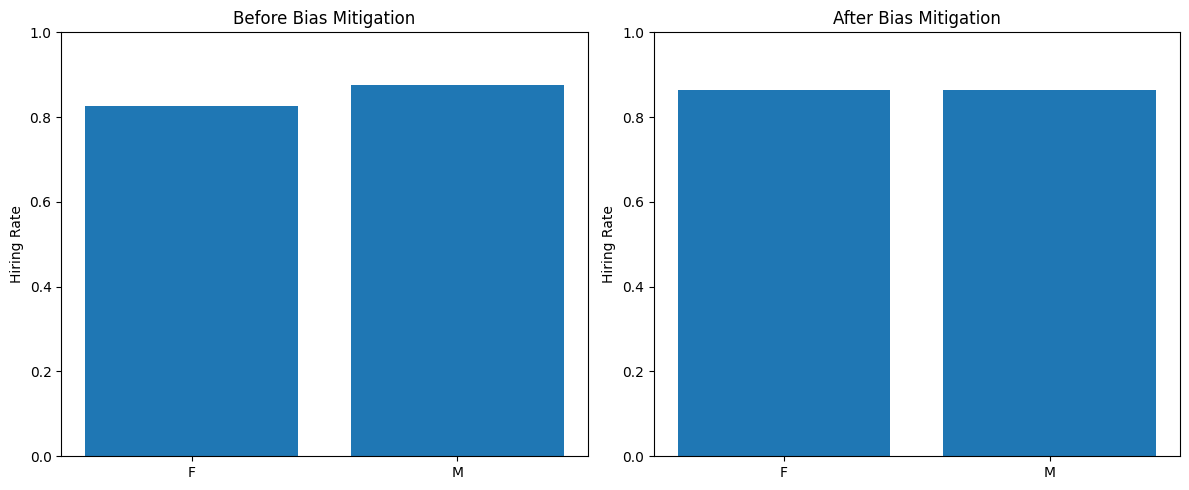

Demo completed. Questions?


In [37]:
# Create comparison visualization
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Before mitigation
# Creates a DataFrame with gender and original AI predictions
test_df_original = pd.DataFrame({
    'gender': s_test, 
    'prediction': y_pred
})
# Calculates hiring rate for each gender from original AI
hiring_rates_original = test_df_original.groupby('gender')['prediction'].mean()

# Create "Before" Bar Chart
axes[0].bar(hiring_rates_original.index, hiring_rates_original.values)
axes[0].set_title('Before Bias Mitigation')
axes[0].set_ylabel('Hiring Rate')
axes[0].set_ylim(0, 1)

# After mitigation
test_df_fair = pd.DataFrame({
    'gender': s_test, 
    'prediction': y_pred_fair
})
hiring_rates_fair = test_df_fair.groupby('gender')['prediction'].mean()

# Create "After" Bar Chart
axes[1].bar(hiring_rates_fair.index, hiring_rates_fair.values)
axes[1].set_title('After Bias Mitigation')
axes[1].set_ylabel('Hiring Rate')
axes[1].set_ylim(0, 1)

# Finalize and Display
plt.tight_layout()
plt.show()

print("Demo completed. Questions?")